# Subbundles Part 5: Clustering

**Subbundle** - a subgroup of streamlines with a set of common properties

In [10]:
from utils import *

import time

import numpy as np
import pandas as pd

from pyclustertend import hopkins, assess_tendency_by_metric

from sklearn.cluster import MeanShift, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

import scipy.cluster.hierarchy as spc
from scipy.cluster.hierarchy import dendrogram


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Streamline Profiles (from Part 3)

In [11]:
dataset_name = 'HCP_retest'
# dataset_name = 'HCP'

In [12]:
# subjects = get_subjects(dataset_name)
subjects = get_subjects_small(dataset_name)
# subjects = get_subjects_medium(dataset_name)
# subjects = ['105923']
# subjects = ['103818']

In [13]:
myafq = get_afq(dataset_name)
display(myafq.data_frame)

INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /Users/bloomdt/AFQ_data/templates 
INFO:dipy.data.fetcher:Dataset is already in place. If you want to fetch it again please first remove the folder /Users/bloomdt/AFQ_data/callosum_templates 


,subject,dwi_file,bvec_file,bval_file,custom_tract,reg_subject,ses,timing,sl_counts,results_dir,gtab,dwi_affine,dwi_img
0,103818,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,None,None,01,"{'Tractography': 0, 'Registration': 0, 'Segmen...",n_streamlines n_clean_streamline...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,<dipy.core.gradients.GradientTable object at 0...,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
1,105923,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,None,None,01,"{'Tractography': 0, 'Registration': 0, 'Segmen...",n_streamlines n_clean_streamline...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,<dipy.core.gradients.GradientTable object at 0...,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
2,111312,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,None,None,01,"{'Tractography': 0, 'Registration': 0, 'Segmen...",n_streamlines n_clean_streamline...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,<dipy.core.gradients.GradientTable object at 0...,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
3,114823,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,None,None,01,"{'Tractography': 0, 'Registration': 0, 'Segmen...",n_streamlines n_clean_streamline...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,<dipy.core.gradients.GradientTable object at 0...,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
4,115320,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,None,None,01,"{'Tractography': 0, 'Registration': 0, 'Segmen...",n_streamlines n_clean_streamline...,/Users/bloomdt/AFQ_data/hcp_retest/derivatives...,<dipy.core.gradients.GradientTable object at 0...,"[[-1.25, 0.0, 0.0, 90.0], [0.0, 1.25, 0.0, -12...",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...


In [14]:
# bundle_names = [*myafq.bundle_dict]
bundle_names = ['SLF_L', 'SLF_R']
# bundle_names = ['ARC_L', 'ARC_R', 'CST_L', 'CST_R', 'FP'] 
# bundle_names = ['SLF_L', 'SLF_R', 'ARC_L', 'ARC_R', 'CST_L', 'CST_R', 'FP']
# bundle_names = ['SLF_L']
# bundle_names = ['SLF_R']

In [15]:
target_dirs = {}
fa_values = {}
warped_fa_values = {}
md_values = {}
warped_md_values = {}

for subject in subjects:
    target_dirs[subject] = {}
    
    loc = get_iloc(myafq, subject)

    for bundle_name in bundle_names:
        target_dir = get_dir_name(myafq, dataset_name, bundle_name, loc)
        target_dirs[subject][bundle_name] = target_dir

## Adjacencies (From Part 4)

In [16]:
adjacencies = {}
adjacencies_names = {}

for subject in subjects:
    adjacencies[subject] = {}
    adjacencies_names[subject] = {}
    for bundle_name in bundle_names:
        target_dir = target_dirs[subject][bundle_name]
#         adjacencies[subject][bundle_name] = get_adjacencies(target_dir, '*wt*pairwise*')
        adjacencies[subject][bundle_name] = get_adjacencies(target_dir)
#         adjacencies_names[subject][bundle_name] = get_adjacencies_names(target_dir, '*wt*pairwise*')
        adjacencies_names[subject][bundle_name] = get_adjacencies_names(target_dir)

In [17]:
adjacencies_df = pd.DataFrame.from_dict(
    {(i,j): pd.Series(adjacencies_names[i][j]) for i in adjacencies_names.keys() for j in adjacencies_names[i].keys()}, 
    orient='index'
)

with pd.option_context('display.max_colwidth', -1):
    display(adjacencies_df)
    
# os.makedirs(op.join('subbundles', dataset_name), exist_ok=True)
# f_name = op.join('subbundles', dataset_name, f'adjacencies_names.csv')
# print(f_name)
# adjacencies_df.to_csv(f_name)

0      1       2   3                      4                 5  \
103818 SLF_L  fa  fa_r2  is_mdf  md  pairwise_warped_fa_r2  ref_warped_fa_r2   
       SLF_R  fa  fa_r2  is_mdf  md  pairwise_warped_fa_r2  ref_warped_fa_r2   
105923 SLF_L  fa  fa_r2  is_mdf  md  pairwise_warped_fa_r2  ref_warped_fa_r2   
       SLF_R  fa  fa_r2  is_mdf  md  pairwise_warped_fa_r2  ref_warped_fa_r2   

                                 6                                     7  \
103818 SLF_L  wt_0_fa_r2_10_is_mdf  wt_0_pairwise_warped_fa_r2_10_is_mdf   
       SLF_R  wt_0_fa_r2_10_is_mdf  wt_0_pairwise_warped_fa_r2_10_is_mdf   
105923 SLF_L  wt_0_fa_r2_10_is_mdf  wt_0_pairwise_warped_fa_r2_10_is_mdf   
       SLF_R  wt_0_fa_r2_10_is_mdf  wt_0_pairwise_warped_fa_r2_10_is_mdf   

                                            8                    9  ...  \
103818 SLF_L  wt_0_ref_warped_fa_r2_10_is_mdf  wt_1_fa_r2_9_is_mdf  ...   
       SLF_R  wt_0_ref_warped_fa_r2_10_is_mdf  wt_1_fa_r2_9_is_mdf  ...   
105923 SLF_L  wt_0_ref_warped_fa_r2_10_is_mdf  wt_1_fa_r2_9_is_mdf  ...   
       SLF_R  wt_0_ref_warped_fa_r2_10_is_mdf  wt_1_fa_r2_9_is_mdf  ...   

                                          29                   30  \
103818 SLF_L  wt_7_ref_warped_fa_r2_3_is_mdf  wt_8_fa_r2_2_is_mdf   
       SLF_R  wt_7_ref_warped_fa_r2_3_is_mdf  wt_8_fa_r2_2_is_mdf   
105923 SLF_L  wt_7_ref_warped_fa_r2_3_is_mdf  wt_8_fa_r2_2_is_mdf   
       SLF_R  wt_7_ref_warped_fa_r2_3_is_mdf  wt_8_fa_r2_2_is_mdf   

                                               31  \
103818 SLF_L  wt_8_pairwise_warped_fa_r2_2_is_mdf   
       SLF_R  wt_8_pairwise_warped_fa_r2_2_is_mdf   
105923 SLF_L  wt_8_pairwise_warped_fa_r2_2_is_mdf   
       SLF_R  wt_8_pairwise_warped_fa_r2_2_is_mdf   

                                          32                   33  \
103818 SLF_L  wt_8_ref_warped_fa_r2_2_is_mdf  wt_9_fa_r2_1_is_mdf   
       SLF_R  wt_8_ref_warped_fa_r2_2_is_mdf  wt_9_fa_r2_1_is_mdf   
105923 SLF_L  wt_8_ref_warped_fa_r2_2_is_mdf  wt_9_fa_r2_1_is_mdf   
       SLF_R  wt_8_ref_warped_fa_r2_2_is_mdf  wt_9_fa_r2_1_is_mdf   

                                               34  \
103818 SLF_L  wt_9_pairwise_warped_fa_r2_1_is_mdf   
       SLF_R  wt_9_pairwise_warped_fa_r2_1_is_mdf   
105923 SLF_L  wt_9_pairwise_warped_fa_r2_1_is_mdf   
       SLF_R  wt_9_pairwise_warped_fa_r2_1_is_mdf   

                                          35                    36  \
103818 SLF_L  wt_9_ref_warped_fa_r2_1_is_mdf  wt_10_fa_r2_0_is_mdf   
       SLF_R  wt_9_ref_warped_fa_r2_1_is_mdf  wt_10_fa_r2_0_is_mdf   
105923 SLF_L  wt_9_ref_warped_fa_r2_1_is_mdf  wt_10_fa_r2_0_is_mdf   
       SLF_R  wt_9_ref_warped_fa_r2_1_is_mdf  wt_10_fa_r2_0_is_mdf   

                                                37  \
103818 SLF_L  wt_10_pairwise_warped_fa_r2_0_is_mdf   
       SLF_R  wt_10_pairwise_warped_fa_r2_0_is_mdf   
105923 SLF_L  wt_10_pairwise_warped_fa_r2_0_is_mdf   
       SLF_R  wt_10_pairwise_warped_fa_r2_0_is_mdf   

                                           38  
103818 SLF_L  wt_10_ref_warped_fa_r2_0_is_mdf  
       SLF_R  wt_10_ref_warped_fa_r2_0_is_mdf  
105923 SLF_L  wt_10_ref_warped_fa_r2_0_is_mdf  
       SLF_R  wt_10_ref_warped_fa_r2_0_is_mdf  

[4 rows x 39 columns]

## [Cluster Tendency Metrics](https://en.wikipedia.org/wiki/Cluster_analysis#Cluster_Tendency)

- [Hopkins Statistics](https://en.wikipedia.org/wiki/Hopkins_statistic)

A statistical hypothesis test where the null hypothesis is that the data is generated by a Poisson point process (and are thus uniformly randomly distributed)

**Scores between 0 and 1, a score around 0.5 express no clusterability and a score tending to 0 express a high cluster tendency.**


- [Silhouette _(using Kmeans)_](https://en.wikipedia.org/wiki/Silhouette_(clustering))

The **silhouette** is a measure of how similar an object is to its own cluster (*cohesion*) compared to other clusters (*separation*).

Assumes a minimum of two clusters. 

**Returns the recommended number of clusters based on silhouette score, where the best score is 1 and worst is -1. Note that values near 0 indicate overlapping clusters.**

## Permute/reorder matrix by similarity

- this becomes convex optimization problem

- many clustering algorithms would work for this setup

### [Dimensionality Reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction)

Dimensionality reduction can be thought of as a neutral clustering model

##### <span style="color:red">NOTE: There are many [dimensionality reduction techniques](https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/) available to choose from.</span>

- <span style="color:red">**Question: Which others make sense to explore? and how to compare?**</span>


- [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) (*Principle Component Analysis*)

- ICA (*Independent Component Analysis*)

- t-SNE (*t-distributed Stochastic Neighbor Embedding*)

- ...

### PCA

##### <span style="color:red">NOTE: `n_components` is hardcoded</span>

- at the moment focused on SLF which believe from literature to have 3 subbundles

#### NOTE that the eigenvectors are very short and hard to see in this

#### WARNING: Using clustering results from below to color code clusters

## Clustering

- For every streamline assign class given collection in unsupervised manner

  - Then label clusters
    
    - To identify number of clusters use empirical test like F-test

###  [Spectral Clustering](https://en.wikipedia.org/wiki/Spectral_clustering)

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html

### Multiple Adjacency Spectral Embedding (MASE)

Following tutorial from:

https://graspologic.readthedocs.io/en/latest/tutorials/embedding/MASE.html

See: *On a two-truths phenomenon in spectral graph clustering* https://www.pnas.org/content/116/13/5995

103818 SLF_L


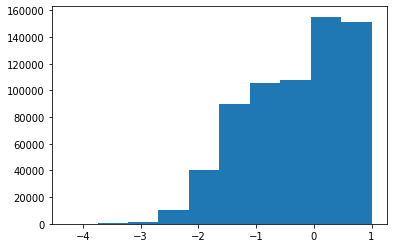

symmetric:  True
finite:  True
min:  -4.269909582619948
max:  1.0


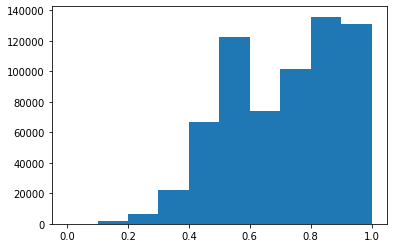

symmetric:  True
finite:  True
min:  0.0
max:  1.0
103818 SLF_R


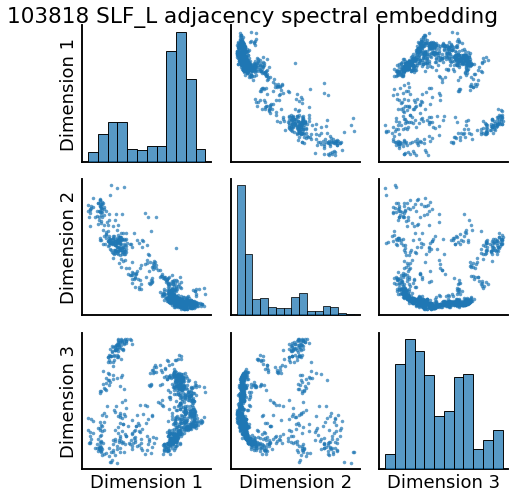

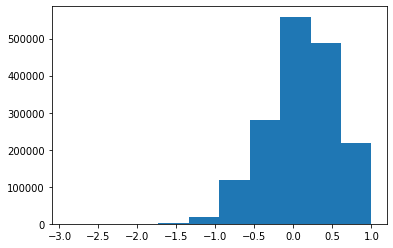

symmetric:  True
finite:  True
min:  -2.902960030224037
max:  1.0


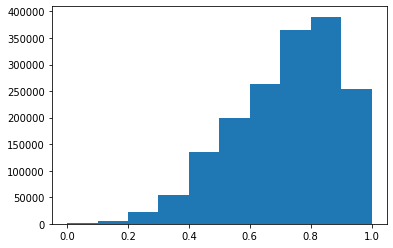

symmetric:  True
finite:  True
min:  0.0
max:  1.0
105923 SLF_L


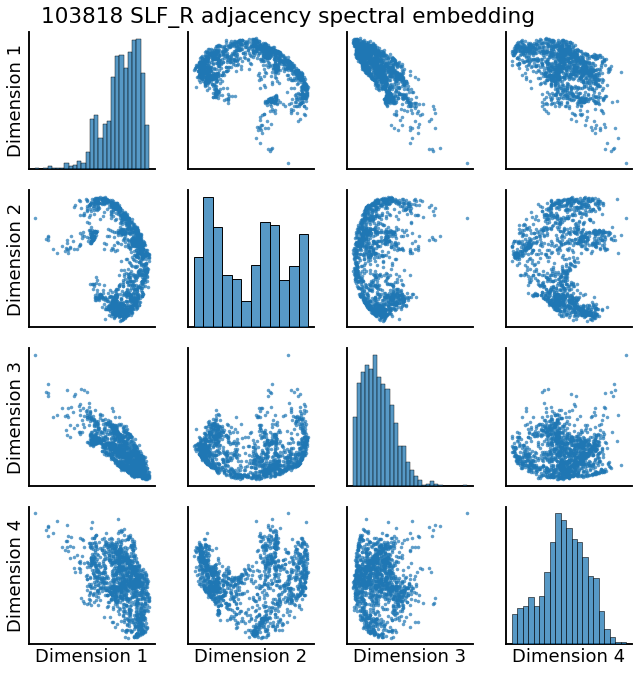

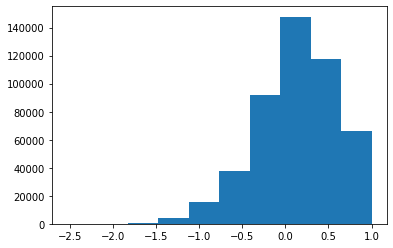

symmetric:  True
finite:  True
min:  -2.534102337014289
max:  1.0


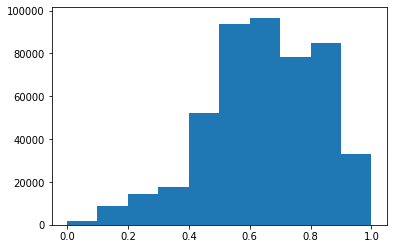

symmetric:  True
finite:  True
min:  0.0
max:  1.0
105923 SLF_R


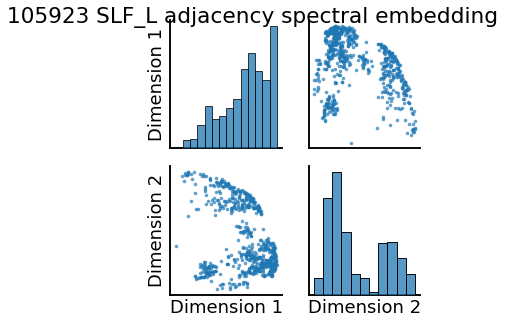

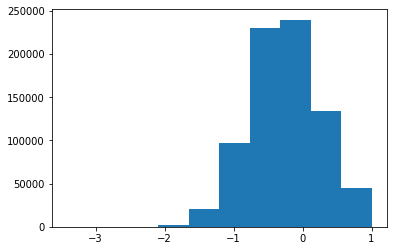

symmetric:  True
finite:  True
min:  -3.412286809627229
max:  1.0


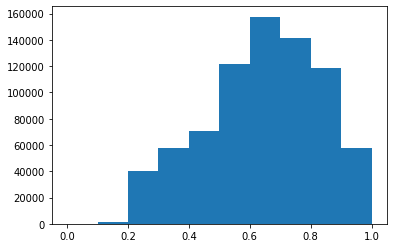

symmetric:  True
finite:  True
min:  0.0
max:  1.0


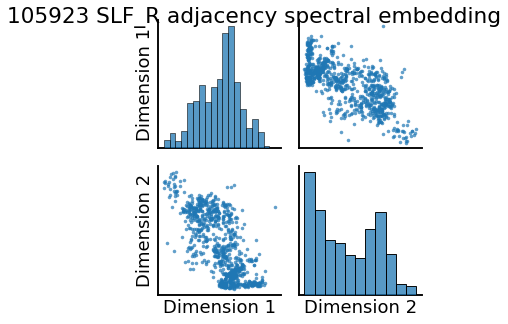

In [20]:
from graspologic.embed import MultipleASE as MASE
from graspologic.cluster import KMeansCluster
from graspologic.plot import heatmap, pairplot
import math

mase_idxs = {}

# For now testing just combination of pairwise and is mdf
embedder = MASE()

for subject in subjects:
    mase_idxs[subject] = {}
    for bundle_name in bundle_names:
        print(subject, bundle_name)
        
        mase_idxs[subject][bundle_name] = []
        
        tissue = adjacencies[subject][bundle_name][adjacencies_names[subject][bundle_name].index('pairwise_warped_fa_r2')]        
#         adjacency_test(tissue)
#         heatmap(tissue, figsize=(4,4), title=f"{dataset_name} {subject} {bundle_name} Pairwise FA $R^2$", cbar=False)
        
        distance = adjacencies[subject][bundle_name][adjacencies_names[subject][bundle_name].index('is_mdf')]
#         adjacency_test(distance)
#         heatmap(distance, figsize=(4,4), title=f"{dataset_name} {subject} {bundle_name} Inverse Scaled MDF", cbar=False)

#         print('diff:', distance-distance.T)
#         print('nonzero diff:', np.count_nonzero(distance-distance.T))
#         print('nonzero diff ids:', np.nonzero(distance-distance.T))        
#         print('abs diff:', abs(distance-distance.T))
#         print('nonzero abs diff:', np.count_nonzero(abs(distance-distance.T)))
#         print('nonzero abs diff ids:', np.nonzero(abs(distance-distance.T)))

#         print('sum diff:', np.sum(abs(distance-distance.T)))
#         print('fsum diff:', math.fsum((distance-distance.T).flatten()))
#         print((distance-distance.T).sum())
#         print('abs diff sum:', abs(distance-distance.T).sum())
        
        V_hat = embedder.fit_transform([tissue, distance])
        
#         if type(V_hat) is tuple:
#             display('latent left', embedder.latent_left_)
#             display('latent right', embedder.latent_right_)
            
#             display('array_equal', np.array_equal(embedder.latent_left_, embedder.latent_right_))
#             display('array_equiv', np.array_equiv(embedder.latent_left_, embedder.latent_right_))
#             display('allclose', np.allclose(embedder.latent_left_, embedder.latent_right_))
#             display('diff', embedder.latent_left_ - embedder.latent_right_)
            
#             display('score left', embedder.scores_[0])
#             display('score right', embedder.scores_[1])

#             display('sv left', embedder.singular_values_[0])
#             display('sv right', embedder.singular_values_[1])
#         else:
#             display('latent', embedder.latent_left_)
#             display('score', embedder.scores_)
#             display('sv', embedder.singular_values_)

        
#         plt.figure()
#         plt.scatter(embedder.latent_left_.T[0], embedder.latent_left_.T[1])
#         plt.title(f'{dataset_name}  {subject} {bundle_name} latent left\nsingular values {embedder.singular_values_}')
#         plt.show()
        
#         if type(V_hat) is tuple:
#             _ = pairplot(V_hat[0], title=f'{dataset_name} {subject} {bundle_name} adjacency spectral embedding')
#             _ = pairplot(V_hat[1], title=f'{dataset_name} {subject} {bundle_name} adjacency spectral embedding')
#         else:
        _ = pairplot(V_hat, title=f'{subject} {bundle_name} adjacency spectral embedding')
        
#         if embedder.latent_right_ is not None:
#             plt.figure()
#             plt.scatter(embedder.latent_right_.T[0], embedder.latent_right_.T[1])
#             plt.title(f'{dataset_name}  {subject} {bundle_name} latent right\nsingular values{embedder.singular_values_}')
#             plt.show()
        

        # for now using KMeans and hardcoding number of clusters for SLF, could use AutoGMMCluster
        clusterer = KMeansCluster(3)
#         if type(V_hat) is tuple:
#             idx = clusterer.fit_predict(V_hat[0])
#         else:
        idx = clusterer.fit_predict(V_hat)
            
        mase_idxs[subject][bundle_name].append(idx)

        f_name = op.join(target_dir, f'mase_pairwise_warped_fa_r2_is_mdf_idx.npy')
        np.save(f_name, idx)

### Distribution model: Gaussian mixture models (GMM)

https://scikit-learn.org/stable/modules/mixture.html#mixture

##### <span style="color:red">NOTE: Despite BIC and AIC results manually setting `n_components=3` to the desired number of clusters.</span>

### Centroid Model: MeanShift

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html#sklearn.cluster.MeanShift

##### <span style="color:red">NOTE: There is a `bandwidth` parameter taking default, so bandwidth is estimated using `sklearn.cluster.estimate_bandwidth`.</span>

### Connectivity Model: Hierarchical Clusters

Following example from:

https://stackoverflow.com/questions/52787431/create-clusters-using-correlation-matrix-in-python/52787518#52787518

Using [`scipy.cluster` Hierarchical Clustering package](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html#module-scipy.cluster.hierarchy)

- see https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html#module-scipy.cluster.hierarchy

##### <span style="color:red">NOTE: The dendrogram can be used to manually tune the threshold to desired number of clusters.</span>

- Here setting `p` level to `1` since expect SLF bundle to have 2 or 3 subbundles

##### <span style="color:red">NOTE: Manually setting threshold based on dendrogram</span>

- However, it would be better to learn threshold

## Resort the matrix based on cluster

This is just a visualization of clusters. It is meant as a baselines sanity check for clustering, and does not save output. Additional visualization and statistics are caluclated in part 6.

In [ ]:
def resort_cluster_ids(idx):
    from_values = np.flip(np.argsort(np.bincount(idx))[-(np.unique(idx).size):])
    to_values = np.arange(from_values.size)
    d = dict(zip(from_values, to_values))
    new_idx = np.copy(idx)
    for k, v in d.items(): new_idx[idx==k] = v
    return new_idx

In [ ]:
# load adjacencies into dataframes to simplify sorting
dfs = {}

for subject in subjects:
    dfs[subject] = {}
    for bundle_name in bundle_names:
        dfs[subject][bundle_name] = []
        for adjacency in adjacencies[subject][bundle_name]:
            dfs[subject][bundle_name].append(pd.DataFrame.from_records(adjacency))

**Treating MASE separately since a combination of adjacencies**

In [ ]:
model_type = 'MASE'
model_name = 'pairwise_warped_fa_r2_is_mdf'

ii = [adjacencies_names[subject][bundle_name].index('pairwise_warped_fa_r2'), adjacencies_names[subject][bundle_name].index('is_mdf')]

for subject in subjects:
    for bundle_name in bundle_names:
        target_dir = target_dirs[subject][bundle_name]
        idx = mase_idxs[subject][bundle_name][0]
        
        for i in ii:
            adjacency_name = adjacencies_names[subject][bundle_name][i]
            adjacency =  adjacencies[subject][bundle_name][i]
            
            plt.figure()
            plt.title(f'{dataset_name} {subject} {bundle_name} {adjacency_name} original')
            plt.imshow(adjacency, cmap='hot', interpolation='nearest')
            plt.xlabel('streamline index')
            plt.ylabel('streamline index')
            plt.colorbar()
            plt.show()
        
        columns = [dfs[subject][bundle_name][0].columns.tolist()[j] for j in list((np.argsort(resort_cluster_ids(idx))))]
        clust_df = dfs[subject][bundle_name][0].reindex(columns, axis=1)

        rows = [dfs[subject][bundle_name][0].T.columns.tolist()[j] for j in list((np.argsort(resort_cluster_ids(idx))))]
        clust_df = clust_df.reindex(rows, axis=0)

        labels, counts = np.unique(resort_cluster_ids(idx), return_counts=True)
        
        plt.figure()
        plt.title(f'{dataset_name} {subject} {bundle_name} {model_type} {model_name} custer freq')
        plt.bar(labels, counts, align='center')
        plt.gca().set_xticks(labels)
        plt.ylabel('streamline frequency')
        plt.xlabel('cluster label')
        f_name = op.join(target_dir, f'{model_type}_{model_name}_hist.png')
        print(f_name)
        plt.savefig(f_name)
        plt.show()
                
        plt.figure()
        plt.title(f'{dataset_name} {subject} {bundle_name} {model_type} {model_name} sorted')
        plt.imshow(clust_df, cmap='hot', interpolation='nearest')
        plt.xlabel('streamline index')
        plt.ylabel('streamline index')
        plt.colorbar()
        f_name = op.join(target_dir, f'{model_type}_{model_name}.png')
        print(f_name)
        plt.savefig(f_name)
        plt.show()
                    

<span style="color:blue">**TODO add test retest check**</span>

Note these are going to be of different sizes and will have different streamlines, but would like to get some sense of how clusters changed.

e.g., High level check: are there similar numbers (or ratio) of streamlines per cluster? Is there some way to determine if 'similar' streamlines are classified differently? Is there a way to identify these streamliens?